In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt
import pickle
import torch
from utils.preprocess_utils import *

In [23]:
nontime = pd.read_csv('data/original/nontime_data.txt', sep = ' ')
time = pd.read_csv('data/original/time_data.txt', sep = ' ')

In [24]:
nontime

,HDONG_NM,HDONG_CD,time,tot_pop,age_80U,AREA
0,고산1동,2726067000,evening,32460,0.025970,8881312.38
1,고산1동,2726067000,lunch,32460,0.025970,8881312.38
2,고산1동,2726067000,morning,32460,0.025970,8881312.38
3,고산2동,2726068000,evening,27728,0.031989,24523329.28
4,고산2동,2726068000,lunch,27728,0.031989,24523329.28
...,...,...,...,...,...,...
202,황학동,1114067000,lunch,12609,0.029582,328678.23
203,황학동,1114067000,morning,12609,0.029582,328678.23
204,회현동,1114054000,evening,5296,0.071941,847351.57
205,회현동,1114054000,lunch,5296,0.071941,847351.57


In [29]:
code_list = [1114065000, 1114061500, 2726066200, 2726061000, 2711067000,
       2726065100, 1114066500, 2726062000, 2726051000, 1135057000,
       2711068000, 1114068000, 2726068000, 1135063000, 1114067000,
       2711069000, 1114055000, 2726053000, 1135070000, 1114059000,
       1135062400, 1135059500, 1135061200, 1114054000, 2711064000,
       1135061100, 1114062500, 2711066000, 1114064500, 2726055000,
       1135069500, 1135072000, 2726056000, 2711054500, 2726064000,
       1135060000, 2726060100, 1135062500, 2726052000, 2726063000,
       2726069000, 2726065200, 2726059000, 2711051700, 2726057000,
       1114052000, 2726066100, 1135067000, 1114060500, 1135066500,
       2726054000, 2711065000, 1135056000, 2726060200, 2726067000,
       1135058000, 2711058500, 1114063500, 1135064000, 2726056100,
       1135062100, 2726058000, 2711056500, 1135061900, 1135071000,
       1114058000, 1114057000, 2711057500, 2711059500]
       
def name2index(dong_name):
    for idx, code in enumerate(code_list):
        if code == time[time.HDONG_NM == dong_name].HDONG_CD.iloc[0]:
            return(idx)

In [26]:
# load data
time_data = pd.read_csv('data/original/time_data.txt', sep  = ' ') 
time_data = df2npy(time_data)
morning_data = time_data[:,2,:,:]
lunch_data = time_data[:,1,:,:]
evening_data = time_data[:,0,:,:]
morning_data, train_valid_test_loc_index, m_time_scaler = split_train_valid_test(morning_data)
evening_data, _, e_time_scaler = split_train_valid_test(evening_data)
nontime_data = pd.read_csv('data/original/nontime_data.txt', sep = ' ')
notime, no_time_scaler = split_notime_data(nontime_data, train_valid_test_loc_index)


1114068000
11
min 6888.79
mean 10876.579666666667
max 14491.23


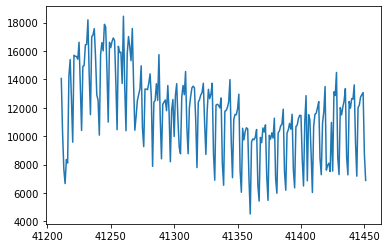

In [21]:
dong_name = '중림동'
plt.plot(time[(time.HDONG_NM == dong_name)&
        (time.time == 'evening')].flow_pop)
print(time[time.HDONG_NM == dong_name].HDONG_CD.iloc[1])
code_list = evening_data[0][:,0,0]
for idx, code in enumerate(code_list):
    if code == time[time.HDONG_NM == dong_name].HDONG_CD.iloc[0]:
        print(idx)
print('min', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].min())
print('mean', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].mean())
print('max', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].max())

1114052000
45
min 22149.75
mean 40489.80933333332
max 51975.97


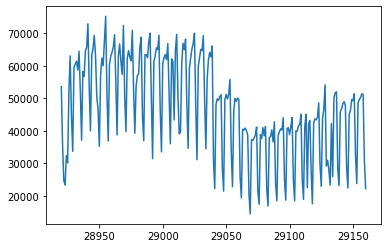

In [22]:
dong_name = '소공동'
plt.plot(time[(time.HDONG_NM == dong_name)&
        (time.time == 'evening')].flow_pop)
print(time[time.HDONG_NM == dong_name].HDONG_CD.iloc[1])
code_list = evening_data[0][:,0,0]
for idx, code in enumerate(code_list):
    if code == time[time.HDONG_NM == dong_name].HDONG_CD.iloc[0]:
        print(idx)
print('min', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].min())
print('mean', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].mean())
print('max', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].max())

1114054000
23
max 70266.17
mean 51307.35599999999
min 31307.16


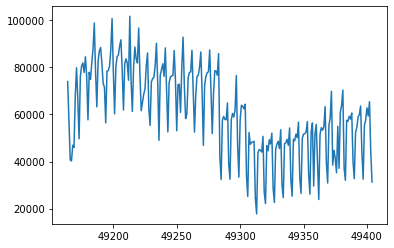

In [20]:
dong_name = '회현동'
plt.plot(time[(time.HDONG_NM == dong_name)&
        (time.time == 'evening')].flow_pop)
print(time[time.HDONG_NM == dong_name].HDONG_CD.iloc[1])
code_list = evening_data[0][:,0,0]
for idx, code in enumerate(code_list):
    if code == time[time.HDONG_NM == dong_name].HDONG_CD.iloc[0]:
        print(idx)
print('max', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].max())
print('mean', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].mean())
print('min', time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].min())


In [27]:
def append_trend_cycle(flow_pop):
    new_flow_pop = np.zeros([len(flow_pop), 2])
    #new_flow_pop[:, 0] = seq2cycle(flow_pop)[ROLLSIZE:]
    new_flow_pop[:, 0] = seq2cycle_weight(flow_pop)
    new_flow_pop[:, 1] = flow_pop - new_flow_pop[:, 0]
    #print(new_flow_pop)
    return new_flow_pop

def split_sequence(sequence, target_index  = 2):
    seq_x = sequence[:, :]
    trend_cycle_x = append_trend_cycle(seq_x[:,target_index])
    seq_x = np.concatenate([seq_x[ROLLSIZE:,:],
                            trend_cycle_x[ROLLSIZE:]], axis = 1)
    return seq_x

In [28]:
time_data = evening_data[3][:,-24:,:]
notime_data = notime
x_time = []
x_notime = []

for loc in range(len(time_data)):
    loc_code = time_data[loc,0,0]
    x = split_sequence(time_data[loc,:,:])
    x_time.append(x.reshape(1, x.shape[0], x.shape[1]))
    no_time = notime_data.loc[loc_code]
    aug_notime = np.zeros(3)
    aug_notime[:] = no_time
    x_notime.append(aug_notime.reshape(1,-1))

x_time = np.concatenate(x_time)
x_notime = np.concatenate(x_notime)

In [30]:
path = 'data/preprocess/'
with open(path + 'evening_last_time.pkl', 'wb') as f:
    pickle.dump(x_time, f)
with open(path + 'evening_last_notime.pkl', 'wb') as f:
    pickle.dump(x_notime, f)